In [1]:
%matplotlib inline
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier

import util

### Data
Our data has been preprocessed in the following ways:<sup>0</sup>

1. Limited to pitcher-batter matchups of 30 or more events.
2. Limited to a select number of pitch types representing common, valid pitches.
3. Limited to events with valid zone location data.

The following columns comprise the data:


| Name | Type | Description |
|------|------|-------------|
| date_stamp | datetime | date of pitch |
| park | string<sup>1</sup> | park in which the pitch was thrown |
| des | string<sup>1</sup> | description of at-bat outcome<sup>2</sup> |
| pdes | string<sup>1</sup> | description of the pitch outcome<sup>3</sup> |
| type | string<sup>1</sup> | swing outcome<sup>4</sup> |
| sz_top | float | top of the strike zone |
| sz_bot | float | bottom of the strike zone |
| mlbam_pitch_name | str<sup>1</sup> | type of pitch<sup>5</sup> |
| zone_location | int<sup>1</sup> | strike zone sector<sup>6</sup> |
| stand | string<sup>1</sup> | side of the plate the batter stands on<sup>7</sup> |
| p_throws | string<sup>1</sup> | hand the pitcher throws with<sup>7</sup> |
| strikes | integer | number of strikes thrown in the current at-bat so far |
| balls | integer | number of balls thrown in the current at-bat so far |
| spin | float | the spin of the ball |
| inning | integer | inning number<sup>8</sup> |
| pfx_x | float | horizontal movement of the pitch<sup>9</sup> |
| pfx_z | float | vertical movement of the pitch<sup>9</sup> |
| x0 | float | initial horizontal position of the pitch<sup>10</sup> |
| y0 | float | initial depth position of the pitch<sup>11</sup> |
| z0 | float | initial vertical position of the pitch |
| vx0 | float | initial horizontal velocity of the pitch |
| vy0 | float | initial forward velocity of the pitch |
| vz0 | float | initial vertical velocity of the pitch |
| ax0 | float | initial horizontal acceleration of the pitch |
| ay0 | float | initial forward acceleration of the pitch |
| az0 | float | initial vertical acceleration of the pitch |
| start_speed | float | initial speed of the pitch |
| px | float| horizontal position of the pitch as it crosses home plate<sup>12</sup> |
| pz | float | height of the pitch as it crosses home plate |


### Goals
The primary goal is to determine the relative importance of various aspects of a pitch on batter performance.
<hr>
One of three things happens when a batter reacts to a pitch:

1. Strike - the batter swings at the ball and misses, or does not swing at a pitch thrown inside the strike zone.
2. Ball - the pitch was thrown outside the strike zone and the batter did not swing at it
3. Contact - the batter makes contact with the ball<sup>13</sup>

<hr>
In order to determine the proportional impact of pitch components, we will build models to predict each of these outcomes. We can then examine the weights assigned by our models to discern which characteristics of a pitch are most important.

### Models

We will use Random Forest Classifiers for our models. These classifiers build multiple Decision Tree classifiers from subsets of the data and then combines the results. This provides us with both flexibility and insurance against over-fitting.

In [2]:
model = RandomForestClassifier(n_estimators=20)

In [10]:
bks_2010 = util.read_brooks(2010)

We can construct models that predict all three potential outcomes (`S`, `B`, `X`) simultaneously, but we first need to format our training data appropriately by creating dummy variables for them.

In [11]:
types = pd.get_dummies(bks_2010.type, prefix='type')

We'll initially train a model on all available columns. We remove the columns we've factorize, as well as the `date_stamp` column. We further remove `factorized_type`, since it represents our dependent variable, and `factorized_des` and `factorized_pdes` since they too represent "outcome" data that would unfairly improve the outcome of our model.

In [29]:
ignore = set(util.FACT_COLS) | {'date_stamp', 'factorized_type', 'factorized_des', 'factorized_pdes'}
predictors = [c for c in bks_2010.columns if c not in ignore]

In [30]:
X_2010 = bks_2010[predictors]

In [31]:
X_2010.dtypes

ab_total                         uint8
ab_count                         uint8
ab_id                            uint8
sz_top                         float64
sz_bot                         float64
strikes                          uint8
balls                            uint8
spin                           float64
norm_ht                        float64
inning                           uint8
pfx_x                          float64
pfx_z                          float64
x0                             float64
y0                             float64
z0                             float64
vx0                            float64
vy0                            float64
vz0                            float64
ax                             float64
ay                             float64
az                             float64
start_speed                    float64
px                             float64
pz                             float64
factorized_pitcher_id            int64
factorized_batter_id     

In [35]:
model.fit(X_2010, types)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

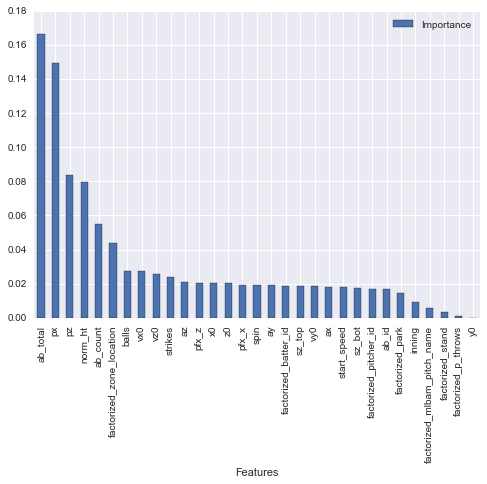

In [50]:
feats = pd.DataFrame({'Features': predictors, 'Importance': model.feature_importances_}).sort_values('Importance', ascending=False)
feats.plot(kind='bar', x='Features', y='Importance')

In [51]:
cross_val_score(model, X_2010, types, scoring='roc_auc').mean()

0.94179798292974581

In [55]:
bks_2011 = util.read_brooks(2011)
X_2011 = bks_2011[predictors]
types_2011 = pd.get_dummies(bks_2011.type, prefix='type')
cross_val_score(model, X_2011, types_2011, scoring='roc_auc').mean()

0.94531357713268982

In [57]:
bks_2012 = util.read_brooks(2012)
X_2012 = bks_2012[predictors]
types_2012 = pd.get_dummies(bks_2012.type, prefix='type')
cross_val_score(model, X_2012, types_2012, scoring='roc_auc').mean()

0.94725643174038299

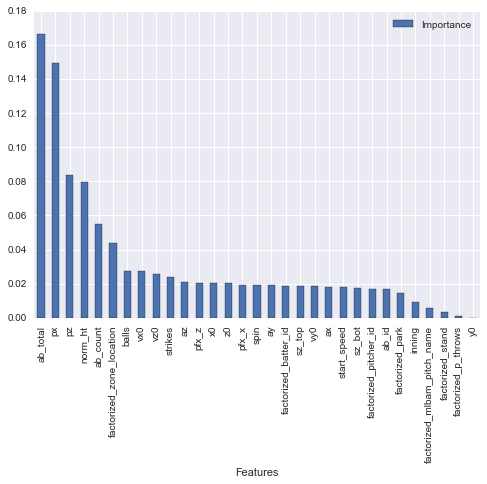

In [58]:
feats = pd.DataFrame({'Features': predictors, 'Importance': model.feature_importances_}).sort_values('Importance', ascending=False)
feats.plot(kind='bar', x='Features', y='Importance')

0.98421098294594012

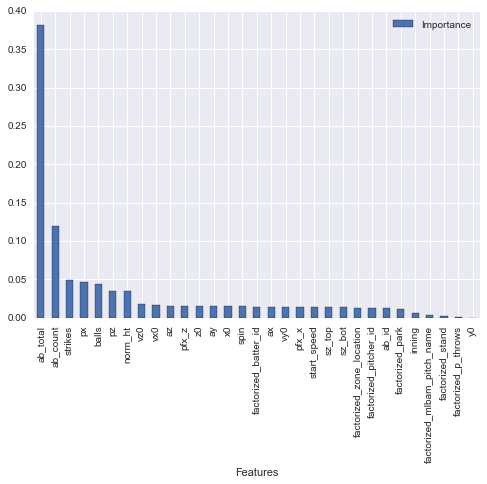

In [62]:
mx = RandomForestClassifier(n_estimators=20)
type_x_2010 = types['type_X']
mx.fit(bks_2010[predictors], type_x_2010)
feats = pd.DataFrame({'Features': predictors, 'Importance': mx.feature_importances_}).sort_values('Importance', ascending=False)
feats.plot(kind='bar', x='Features', y='Importance')
cross_val_score(mx, bks_2010[predictors], type_x_2010, scoring='roc_auc').mean()

0.90312620080614836

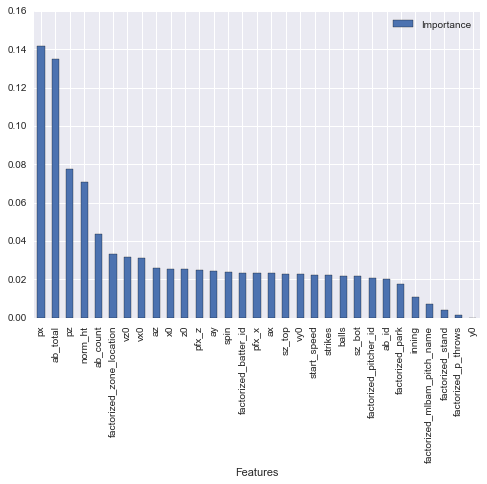

In [61]:
ms = RandomForestClassifier(n_estimators=20)
preds = bks_2010[predictors]
type_s_2010 = types['type_S']
ms.fit(preds, type_s_2010)
feats = pd.DataFrame({'Features': predictors, 'Importance': ms.feature_importances_}).sort_values('Importance', ascending=False)
feats.plot(kind='bar', x='Features', y='Importance')
cross_val_score(ms, preds, type_s_2010, scoring='roc_auc').mean()

0.93253078602690298

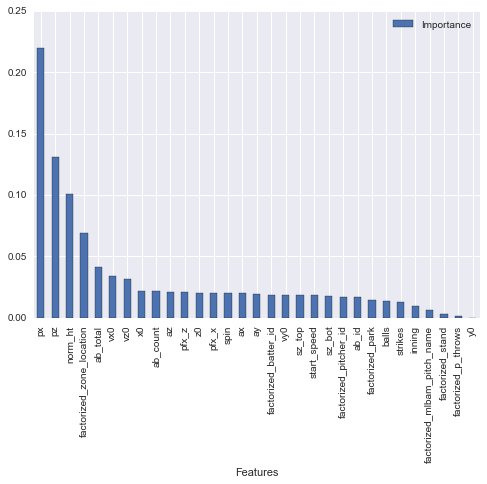

In [63]:
mb = RandomForestClassifier(n_estimators=20)
preds = bks_2010[predictors]
type_b_2010 = types['type_B']
mb.fit(preds, type_b_2010)
feats = pd.DataFrame({'Features': predictors, 'Importance': mb.feature_importances_}).sort_values('Importance', ascending=False)
feats.plot(kind='bar', x='Features', y='Importance')
cross_val_score(mb, preds, type_b_2010, scoring='roc_auc').mean()

<hr><br><br><br><br><br><hr>

<sup>0</sup>: Preprocessing, and other code, can be found in `util.py`.    
<sup>1</sup>: The data in this column has been factorized.    
<sup>2</sup>: The outcome of the pitch&mdash;`Called Strike`, `In play`, `Ball`, `Foul`, etc.    
<sup>3</sup>: The outcome of the at-bat&mdash;`Groundout`, `Home Run`, `Walk`, etc.    
<sup>4</sup>: `B` for Ball, `S` for Strike, or `X` for In Play.    
<sup>5</sup>: `CH` for Changeup, `CU` for Curveball, `FC` for Fastball (Cutter), `FF` for Four-seam Fastball, `FT` for Two-seam Fastball, `SI` for Sinking Fastball, `SL` for Slider.    
<sup>6</sup>: The strike zone is a square the width of home plate, starting roughly at the batter's knees and extending to the midpoint of their torso; pitches thrown outside this square (according to the umpire) are scored as balls, provided the batter doesn't swing at them. The data divides this space into twenty-five equally-sized sections, labeled `0`-`24`, starting in the upper-left.    
<sup>7</sup>: `R` for Right or `L` for Left.    
<sup>8</sup>: 1-9    
<sup>9</sup>: i.e., deviation from a hypothetical straight line drawn from the pitcher to home plate.    
<sup>10</sup>: i.e. left-right, as seen from the axis between the batter and pitcher.    
<sup>11</sup>: i.e. distance from the batter.    
<sup>12</sup>: represented as distance from a vertical line drawn upwards from the center of home plate. Positive values are to the right of this line, negative values are to the left.    
<sup>13</sup>: Not all contact is created equal; triples are more valuable than singles. It should be noted, however, that once a ball is in play, the ultimate result is subject to numerous exogenous factors ranging from wind direction to the foot speed of the nearest fielder, and is thus less representative of a batter's 'true ability' than whether contact was made in the first place.